# FactorFactory Quick Start Guide

This notebook demonstrates how to use the `factorFactory` module from TockFormer. We will walk through the functionality of dependent modules, the class definition and interfaces of `factorFactory`, and provide examples of how to register new factors, generate feature factors, and invoke these factors.

---


## 1. Module Import and Data Construction

Before using the `FactorFactory` module, we need to import the relevant modules and prepare a sample dataset.
The code below creates an artificial stock data `DataFrame` containing `open` and `close` columns, with `timestamp` as the trading date index.

We simulate 200 trading days of opening and closing prices:
First, a random walk price series is generated, then the opening and closing prices for each day are calculated.
This gives us a simple `DataFrame` that can be used with `FactorFactory`.

After constructing the data, we view the first few rows to confirm that the format is correct.

In [1]:
import pandas as pd
import numpy as np

# generate data
dates = pd.date_range("2020-01-01", periods=200, freq='B')  # 200 trading days
np.random.seed(42)
# Simulate daily price changes (random walk + cyclical fluctuation)
drift = 0.01 * np.sin(2 * np.pi * np.arange(200) / 40)      # Cyclical drift
noise = np.random.normal(0, 0.02, size=200)                 # Random noise
daily_return = drift + noise
price = [100]  # Initial price
for r in daily_return[:-1]:  # Update price based on the previous day's return
    price.append(price[-1] * (1 + r))
price = np.array(price)
# Calculate opening price (open) and closing price (close)
open_price = price.copy()
close_price = price * (1 + daily_return)  # Close price = Open price * (1 + daily return)
df = pd.DataFrame({
    'timestamp': dates,
    'open': open_price,
    'close': close_price
})

print(df.head(3))  # View the first 3 rows of data

   timestamp        open       close
0 2020-01-01  100.000000  100.993428
1 2020-01-02  100.993428  100.872141
2 2020-01-03  100.872141  102.490528


As we can see, each row in the dataset corresponds to a trading day and includes the date, opening price, and closing price.
Next, we will use this data to initialize the FactorFactory and generate trading factors.


---


## 2. Initializing FactorFactory

Now, we will initialize the `FactorFactory` using the generated data.
During initialization, we need to provide the data `DataFrame` along with several key parameters:

- `target_col`: Specifies the target column (default is `'close'`)
- `forward_period`: Sets the number of look-ahead days (used to compute future returns and classification labels)
- `window`: Window size used to calculate rolling evaluation metrics
- `scaler`: Defines the normalization method for evaluation metrics (e.g., `'minmax'`)
- `top_k`: Number of top-scoring factors to retain

The following code creates a `FactorFactory` instance.
We especially highlight the `forward_period` parameter. For example, setting it to `5` means we are forecasting the return over the next 5 days—i.e., comparing today’s closing price with the closing price 5 days later to determine the up/down label.

Subsequent evaluations of factors (e.g., IC, IR) will also be based on the return over this `forward_period=5`.
We also set `top_k=10` so that only the top 10 highest-scoring factors are retained after each evaluation round, which simplifies the demonstration.


In [2]:
from Utility.factorFactory import FactorFactory

# Initialize FactorFactory with forward_period=5 days, retaining only the top 10 factors
factory = FactorFactory(df, forward_period=5, window=20, scaler='minmax', top_k=10)
print("FactorFactory initialization completed. Base columns:", factory.base_cols)
print("forward_period parameter:", factory._eval_kwargs['forward_period'], "days")

/Users/ziwenchen/miniconda3/envs/TockFormer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FactorFactory initialization completed. Base columns: ['open', 'close']
forward_period parameter: 5 days


This confirms that the FactorFactory is now ready. It will use the `open` and `close` columns as the raw features and evaluate the factors based on the price movement over the next 5 days.
Specifically, if the return 5 days later is positive, it will be classified as an upward movement; if the return is negative, it will be classified as a downward movement.

---

## 3. Generating First-Order Factors (The `generate_factors` Method)

Next, we call the `generate_factors` method of `FactorFactory` to compute first-order factors.
First-order factors refer to technical indicators or features that are directly calculated from the base columns, such as RSI, moving averages, etc.
In implementation, `generate_factors` applies a set of pre-registered factor functions to each base column and then automatically combines different factors (cross operations) to produce higher-order features.

By default, `generate_factors` includes the following steps:

- **(1) Compute first-order factors**: Apply registered factor functions (such as RSI, SMA, EMA, MACD) to each original data column to obtain various technical indicator factors.

- **(2) Generate cross features**: Perform predefined arithmetic combinations (e.g., addition, multiplication, subtraction, division, sin/cos, etc.) on first-order factors, and apply factor functions again to create second-order and higher-order features.

- **(3) Merge and clean**: Combine all generated factors into a feature matrix and remove columns with constant or missing values.

- **(4) Factor evaluation**: Evaluate the retained factors by computing metrics such as Spearman rank correlation (IC), rolling IC information ratio (IR), and principal component coefficients.
  The results are stored in a summary. Based on our setting `top_k=10`, only the top 10 highest-scoring factors will be kept, and the rest will be discarded.
  During evaluation, a positive return over the next 5 days is treated as a positive class, while a negative return is treated as a negative class—effectively framing it as a binary classification of 5-day price movements.

The following code calls `generate_factors` and displays the generated factor features and evaluation summary:

In [3]:
# Generate first-order and higher-order factor features
df_factors = factory.generate_factors()
print(f"Number of generated factors (excluding the 'timestamp' column): {df_factors.shape[1] - 1}")

🔄 cross_op (single): 100%|██████████| 2700/2700 [00:00<00:00, 43191.10it/s]


Number of generated factors (excluding the 'timestamp' column): 10


In [4]:
print("Last 5 rows of the feature matrix (showing only the first 5 columns as an example):\n")
df_factors.tail(5).iloc[:, :5]

Last 5 rows of the feature matrix (showing only the first 5 columns as an example):



,timestamp,macd_12_26_(rsi_6_(open)),macd_12_26_(rsi_10_(open)),macd_5_20_(open)_minus_sma_20_(open),macd_5_20_(open)_minus_sma_20_(close)
129,2020-09-30,-6.0359,-5.1332,-97.8080,-97.4944
130,2020-10-01,-5.3109,-4.6732,-97.0771,-96.6339
131,2020-10-02,-4.7710,-4.3661,-96.5214,-95.9159
132,2020-10-05,-4.1146,-3.9124,-95.5838,-94.9808
133,2020-10-06,-3.4174,-3.3879,-94.5712,-93.5978


In [5]:
# Output the top 5 factor evaluation summary
print("\nFactor evaluation summary (Top 5 factors):\n")
factory.get_summary().head(5)


Factor evaluation summary (Top 5 factors):



,spearman_ic,pearson_ir,pca_coeff,spearman_ic_norm,pearson_ir_norm,pca_coeff_norm,combined_score
macd_12_26_(rsi_6_(open)),0.5743,0.9872,0.0188,0.9007,0.7041,0.7753,2.3801
macd_12_26_(rsi_10_(open)),0.4940,0.6930,0.0213,0.8448,0.6479,0.8802,2.3730
macd_5_20_(open)_minus_sma_20_(open),0.6666,1.2211,0.0160,0.9648,0.7487,0.6581,2.3716
macd_5_20_(open)_minus_sma_20_(close),0.6921,1.4186,0.0144,0.9825,0.7864,0.5949,2.3638
bbpband_20_1.5_(macd_12_26_(open)),0.5583,0.9558,0.0187,0.8895,0.6981,0.7721,2.3597


The output above shows that **the FactorFactory generated a large number of factors**, and after applying the `top_k=10` strategy, it retained the 10 best-performing factors (excluding the timestamp).

The example displays some of the factor values over time, such as `rsi_6_close`, `rsi_6_open`, and other RSI-related features.
On the right side, the evaluation summary lists each factor's Spearman rank correlation (IC), rolling information ratio (IR), the first principal component loading (`pca_coeff`), and their normalized scores.
The final column, `combined_score`, is a composite score, and the factors are sorted in descending order by this value.

From the results, we can see that short-term RSI and `macd_diff` cross factors achieved the highest scores in predicting 5-day future price movements.
Both their IC and IR values are relatively high, indicating strong factor performance.

---


## 4. Feature Combination and Iterative Generation (`next` Method)

The `FactorFactory` provides a `next` method for iteratively generating more higher-order composite features.
In each iteration, it selects the top-ranked and least correlated $k$ factors from the current factor set, performs combination operations to generate new features, and merges them with the existing features. The updated factor set is then re-evaluated.

You can control the number of iterations using the `steps` parameter, and the number of factors to select for combination in each step using the `k` parameter.

In the example below, we call `factory.next(steps=1, k=2)` to perform one iteration, where 2 of the top-performing factors from the previous step are selected and combined.
Since we set `top_k=10`, only the top 10 scoring factors will be retained after each iteration.
We then view the top 5 factors again after the iteration:


In [6]:
# Perform one iteration of factor generation (combine the 2 least correlated top factors)
factory.next(steps=1, k=2)
print("Top 5 factors after 1 iteration:\n")
factory.get_summary().head(5)

🔄 next steps: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]

Top 5 factors after 1 iteration:



,spearman_ic,pearson_ir,pca_coeff,spearman_ic_norm,pearson_ir_norm,pca_coeff_norm,combined_score
macd_5_20_(open)_minus_sma_20_(close),0.7521,1.6080,0.1964,1.0000,0.9256,0.9653,2.8909
rsi_14_(macd_5_20_(open)_minus_sma_20_(close)),0.7214,1.5727,0.2022,0.9796,0.9155,0.9943,2.8894
bbpband_20_2.0_(macd_12_26_(rsi_6_(open))),0.6861,1.8684,0.1859,0.9561,1.0000,0.9130,2.8691
bbpband_20_1.5_(macd_12_26_(rsi_6_(open))),0.6861,1.8682,0.1859,0.9561,1.0000,0.9130,2.8690
rsi_14_(macd_12_26_(rsi_6_(open))),0.7215,1.3823,0.2033,0.9796,0.8611,1.0000,2.8407


As we can see, a new composite factor ***rsi_14_(macd_diff_12_26_(rsi_6_(open)))*** has appeared in the Top 5 list.
This indicates that newly generated factors through iterative combination may improve the overall factor score.

The `next` method enables us to progressively discover new potentially effective features, and select well-performing factors based on evaluation after each step.

In practice, you can increase the number of `steps` to iterate multiple rounds.
However, note that each round may generate a **large number of features**, so it’s important to control the scale using the `top_k` setting.

---

## 5. 2D Visualization of Factor Structure (`visualize_structure_2d` Method)

To intuitively understand the distribution structure of the generated factors in the sample space,
we can use the `visualize_structure_2d` method to reduce the high-dimensional factor space to two dimensions and visualize it.
This method supports various dimensionality reduction algorithms such as `PCA`, `LLE`, `t-SNE`, and `UMAP` for comparison.

During visualization, each time point is color-coded based on the price movement label over the future `forward_period` days
(up = 1, down = 0).
You can use the `seq_len` parameter to decide whether to expand the time series into sliding windows.
For example, setting `seq_len=5` treats every consecutive 5-day window as a sample for dimensionality reduction,
allowing us to examine the factor distribution over short-term sequence patterns.

Each point in the plot represents the factor value sequence within a 5-day window,
projected onto a 2D plane using each reduction algorithm and color-coded based on the price movement 5 days after the window ends:
***red indicates an upward movement, and blue indicates a downward movement***.
This helps us observe how factors cluster under different market conditions.

🔄 窗口展平: 100%|██████████| 96/96 [00:00<00:00, 47781.32it/s]
/Users/ziwenchen/miniconda3/envs/TockFormer/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
🔄 并行降维: 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]


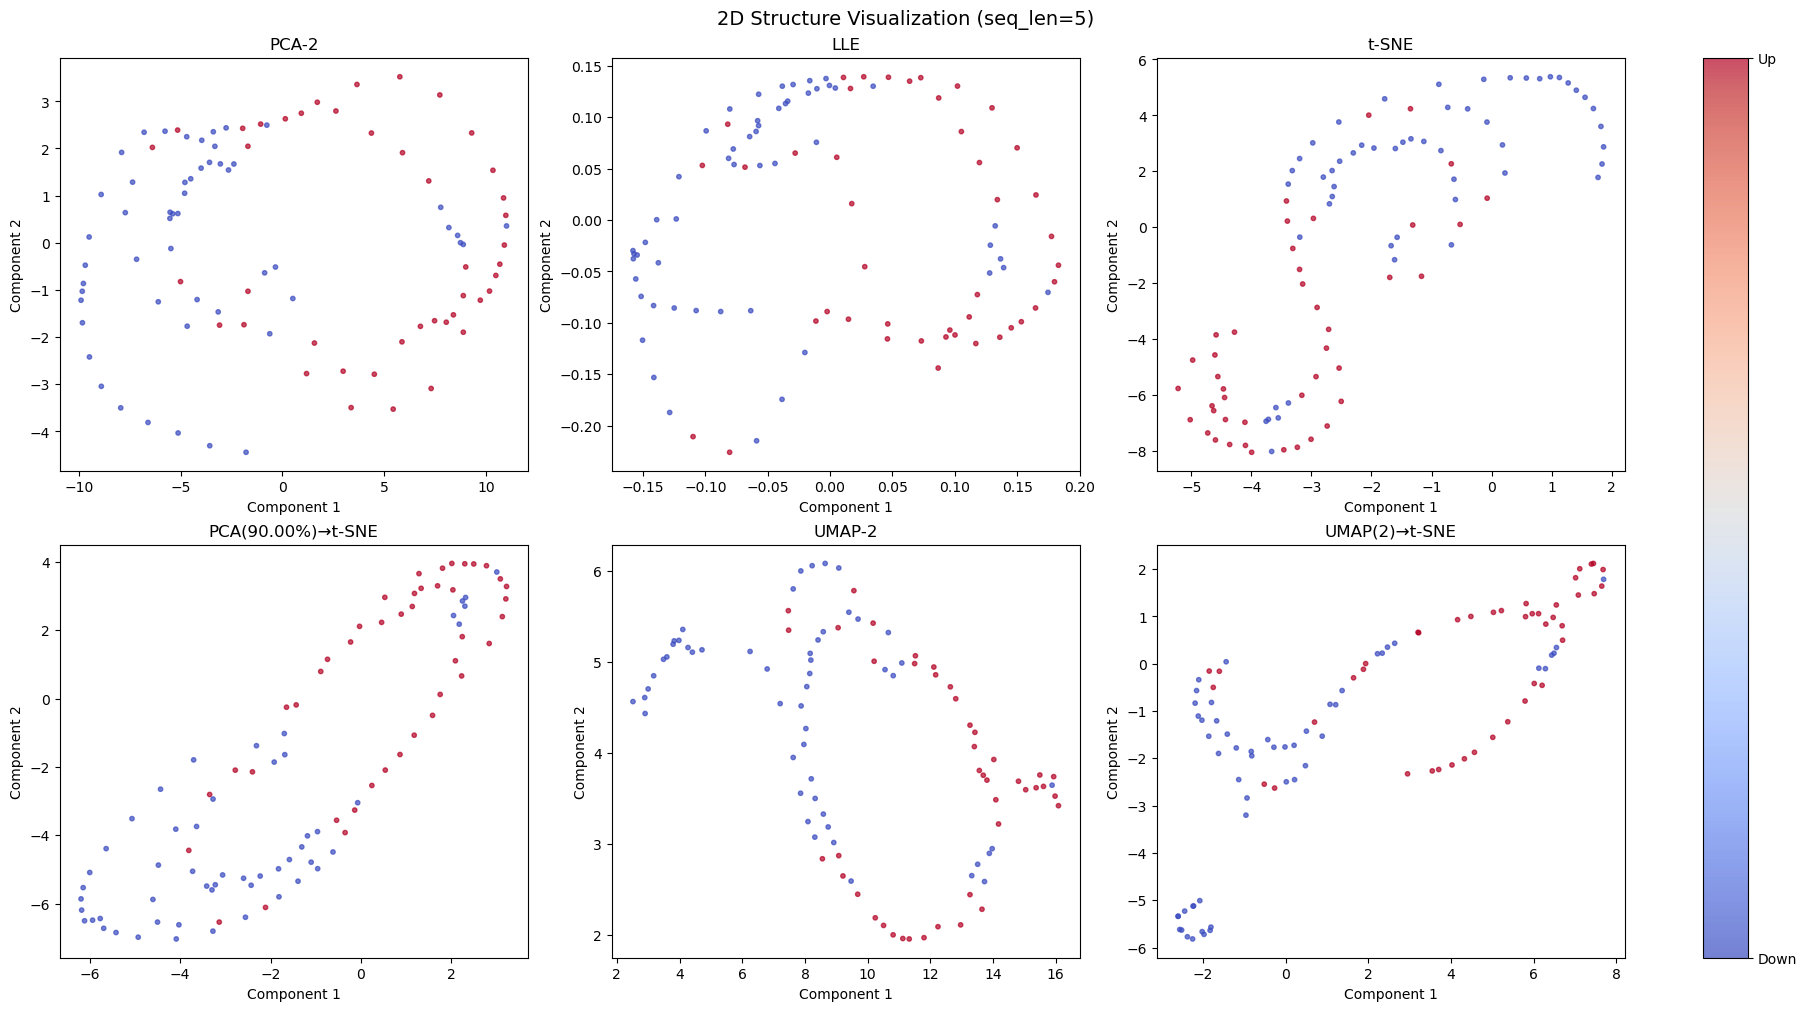

In [7]:
factory.visualize_structure_2d(
    seq_len=5,
    perplexity=30, # for tsne
    n_neighbors=10, # for lle
    random_state=42,
    pca_evp=0.9, # pca explained variance ratio percent to keep
    umap_components=2, # n components for umap
)

From the plot above, we can observe that the combined factors form a certain clustering structure in the 2D space.
Red and blue points show distinct spatial distributions, indicating that the generated factors contain some information useful for distinguishing future price movements.

In other words, samples with different future trends (upward or downward) tend to cluster differently in the factor space,
demonstrating the discriminative power of the factors with respect to future market direction.

Of course, this is just a visual and intuitive validation.
A more precise assessment still relies on quantitative metrics such as factor scores.

---

## 6. Factor Clustering Evaluation (`evaluate_clusterings` Method)

The `FactorFactory` also provides an `evaluate_clusterings` method for performing unsupervised clustering analysis on factor data
and evaluating the effectiveness of various clustering algorithms.

This method tests multiple clustering algorithms
***such as KMeans, Agglomerative Clustering, Spectral Clustering, Gaussian Mixture, DBSCAN, and MeanShift***.
It clusters the factor data (or factor sequence data) using various parameters and computes evaluation metrics
***such as the Silhouette coefficient, Calinski-Harabasz index, and Davies-Bouldin index***.

If `seq_len > 1` is specified, it performs clustering on expanded sequences of factor data,
similar to the visualization approach described earlier, allowing discovery of clustering patterns across short-term factor sequences.

Once clustering evaluation is complete, `evaluate_clusterings` returns a `DataFrame` (also stored in `factory.cluster_report`),
where each row logs the results and evaluation scores of a clustering attempt.
From this, we can identify the most effective clustering configuration.

The code below selects only ***KMeans and Gaussian Mixture (GaussianMixture)*** algorithms,
evaluates the ***Silhouette*** coefficient across different cluster counts, and prints part of the result:

Clustering eval: 100%|██████████| 18/18 [00:00<00:00, 412.11it/s]


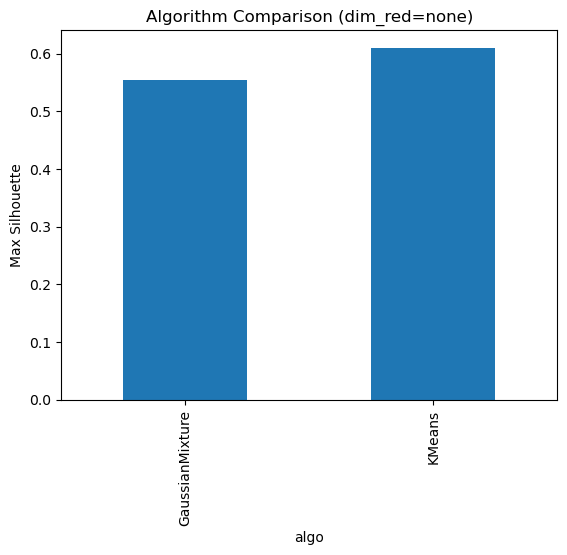

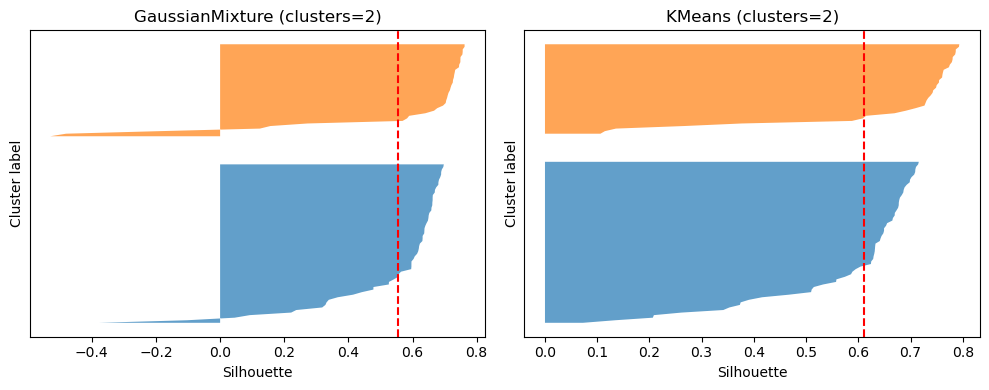

     algo  n_clusters  silhouette
0  KMeans         3.0    0.468179
1  KMeans         2.0    0.610154
2  KMeans         4.0    0.442336
3  KMeans         5.0    0.346056
4  KMeans         6.0    0.361668
5  KMeans         7.0    0.343261
6  KMeans         8.0    0.321008
7  KMeans         9.0    0.311976


In [8]:
cluster_df = factory.evaluate_clusterings(algos=['KMeans','GaussianMixture'],
                                          metrics=['silhouette'],
                                          seq_len=1,
                                          n_jobs=2)
print(cluster_df[['algo','n_clusters','silhouette']].head(8))

From the results, we can observe that the clustering quality varies depending on the algorithm and the number of clusters.
For example, the table shows that for our current factor data, ***KMeans*** achieves the highest ***Silhouette*** score (around 0.18) when using 2 clusters.
Similarly, ***GaussianMixture*** also performs comparably well with 2 clusters.

This suggests that dividing the samples into two clusters might be a reasonable choice
**(potentially corresponding to bullish and bearish market states)**.
Typically, we select the clustering configuration with the highest evaluation metric (e.g., ***Silhouette*** score) for further analysis.

Additionally, `evaluate_clusterings` has already added the cluster labels from the best-performing result
into `self.df_features['cluster']`, making it easy to analyze the performance of each factor group.

For example, we can compute the average IC/IR for each cluster,
or visualize the ***Silhouette*** distribution of different clusters to better understand the diversity of the factor structure.

---
*Tip*: In practical use, you can apply dimensionality reduction before clustering by using the `dim_reduction` parameter.
For example, setting `dim_reduction='pca'` and `reduction_params=[0.9]` will first reduce the dimensionality using PCA,
retaining 90% of the explained variance. This helps to reduce the impact of noise on the clustering results.

---

## 7. Custom Factor Example

`FactorFactory` supports registering custom factor functions using the `@factor` decorator,
allowing new factors to be automatically included during factor generation.

The `Utility.factors` module already includes several predefined common factor functions
(such as RSI, moving averages, Bollinger Bands, etc.),
but you can also define and add your own.

Below is an example demonstrating how to define and register a custom differencing factor:

In [9]:
from Utility.registry import factor, FACTOR_REGISTRY
from typing import Dict, List

@factor(
    category='unbounded', # category label，meaning the output is not bounded
    param_keys=[], # this factor has no parameters
    key_template=lambda params, col: f"diff_({col})" # finalized column name according to columns
)
def diff(
    df: pd.DataFrame,
    cols: List[str]
) -> Dict[str, pd.Series]:
    """
    simple difference factor：diff_col = col_today - col_yesterday
    params:
      - df: original DataFrame，includes the column that needs to be different
      - cols: columns that need to be different
    return:
      - dict: key is diff_{col}，value is the corresponding pd.Series difference result
    """
    out: Dict[str, pd.Series] = {}
    # use @factor' pre-defined key_template
    template = FACTOR_REGISTRY['diff']['key_template']
    for c in cols:
        if c not in df.columns:
            continue
        key = template (None, c) # param_keys are empty, so passing None
        out[key] = df[c].diff()
    return out


#### Why Should Custom Factor Functions Follow This Signature?

In `FactorFactory`, all registered factor functions should follow a standardized function signature:

```python
def my_factor(
    df: pd.DataFrame,
    cols: List[str],
    **kwargs
) -> Dict[str, pd.Series]:
    ...
```

You should also use the `@factor` decorator along with the param_keys and key_template arguments to define metadata for the factor:


```python
@factor(
    category='unbounded',
    param_keys=['alpha'], # name "alpha" has to match the string in def EXAMPLE_FUNC
    key_template=lambda params, col: f"macd_{params[0]}_{params[1]}_{col}"
)
def my_factor(
    df: pd.DataFrame,
    cols: List[str],
    alpha: List[int] = [21, 54]
) -> Dict[str, pd.Series]:
    ...
```

In [10]:
# 注册后再生成因子
factory2 = FactorFactory(df, forward_period=5, top_k=300)
factory2.generate_factors()
print([col for col in factory2.df_features.columns if col.startswith('diff')])

🔄 cross_op (single): 100%|██████████| 3072/3072 [00:00<00:00, 22563.05it/s]


['diff_(open)_minus_sma_20_(open)', 'diff_(open)_minus_sma_20_(close)']


This indicates that the `diff` factors for the `open` and `close` columns have been successfully generated.
We can also inspect their values—for example, ***diff_close*** should equal the current day's closing price minus the previous day's closing price
(with the first day being `NaN` due to the absence of prior data).

In this way, **users can easily extend the factor library of the FactorFactory**.
Simply define a factor computation function and decorate it with `@factor`,
and the factor will be automatically included in future calls to `generate_factors` or `next`,
without needing to manually modify the internal logic of the factory.

---

## 8. Extracting Factor Recipes and Applying to New Data

In [11]:
from Utility.RecipeParser import RecipeParser

rp = RecipeParser()
feature_names_we_want = factory2.df_features.drop(columns='timestamp').columns
recipes = rp.get_recipes(feature_names_we_want)
recipes[5] # randomly select one recipe

{'name': 'macd_5_20_(open)_minus_sma_20_(open)',
 'func': 'minus',
 'inputs': ['macd_5_20_(open)', 'sma_20_(open)'],
 'kwargs': {},
 'subrecipes': [{'name': 'macd_5_20_(open)',
   'func': 'macd',
   'inputs': ['open'],
   'kwargs': {'fast': 5, 'slow': 20},
   'subrecipes': [{'name': 'open',
     'func': None,
     'inputs': ['open'],
     'kwargs': {},
     'subrecipes': []}]},
  {'name': 'sma_20_(open)',
   'func': 'sma',
   'inputs': ['open'],
   'kwargs': {'window': 20},
   'subrecipes': [{'name': 'open',
     'func': None,
     'inputs': ['open'],
     'kwargs': {},
     'subrecipes': []}]}]}

We can now see the detailed configuration of this factor recipe.
With this information, we are able to reproduce the factor on new data using the same logic and parameters.

In [12]:
target_recipe = recipes[5]
df_with_recipe = rp.apply_recipes(df, target_recipe, columns_to_keep= ['timestamp'] + [target_recipe['name']]) # If we don't specify the columns to keep, it will keep all the columns it calculated until the final column it wants

df_with_recipe # first few rows are NAN due to the feature nature

,timestamp,macd_5_20_(open)_minus_sma_20_(open)
0,2020-01-01,NaN
1,2020-01-02,NaN
2,2020-01-03,NaN
3,2020-01-06,NaN
4,2020-01-07,NaN
...,...,...
195,2020-09-30,-97.807972
196,2020-10-01,-97.077128
197,2020-10-02,-96.521358
198,2020-10-05,-95.583767


In summary, the `apply_recipes` method allows you to reproduce any valuable factors discovered during the `next` iterations
and apply them to new datasets with ease.

## 9. Summary

The content above provides a comprehensive demonstration of the core functionality of `FactorFactory`.
From **data preparation**, **factor generation**, and **iterative expansion**,
to **visual analysis**, **clustering evaluation**, and **custom factor extension**,
we have outlined a complete workflow for factor discovery.

In practical applications, you can fine-tune parameters such as `forward_period` and `top_k`,
and continuously add custom factors to enrich the factor library—
ultimately providing more diverse and effective features for quantitative modeling.